# Jun ??st, 2022 (Cartography figure)

**Motivation**:  <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from model.configuration import Config
from model.mouse import Mice
from analysis.bootstrap import *
from analysis.network import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Prepare (512)

In [2]:
mice = Mice(512)

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

In [3]:
task = 'rest'
b = (0.01, 0.5)
mice.setup_func_data(task, band_ca=b)

num_k, p = 7, 20
perc = f'p{p}-sample'
props_base = {
    'kw_kmeans': {'n_init': 100},
    'perc': perc,
    'num_k': num_k,
    'mice': mice,
    'task': task,
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

bt_ca = BootStrap(**props_ca)
bt_bo = BootStrap(**props_bo)

## How mu = 0.003, alpha = 0.05 looks: raw vs. prune

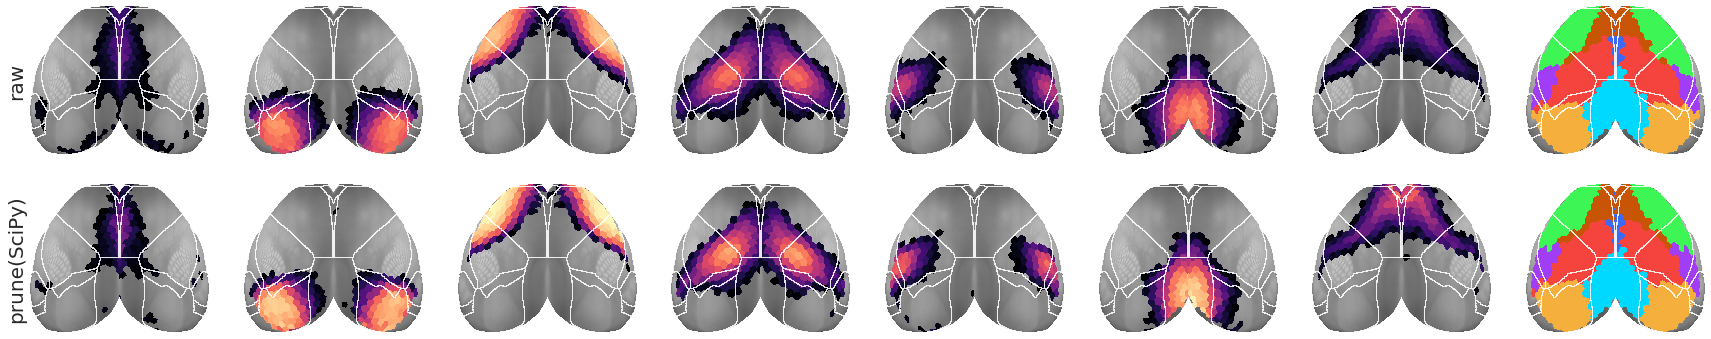

In [4]:
_ = bt_ca.show(
    data={'raw': avg(bt_ca.run_pi), 'prune(SciPy)': avg(bt_ca.pi_prune)},
    figsize=(30, 6),
    ylabel_fontsize=20,
)

In [5]:
[e[-1] for e in bt_ca.pi_symmetry_score(avg(bt_ca.pi_prune))]

[0.972, 0.979]

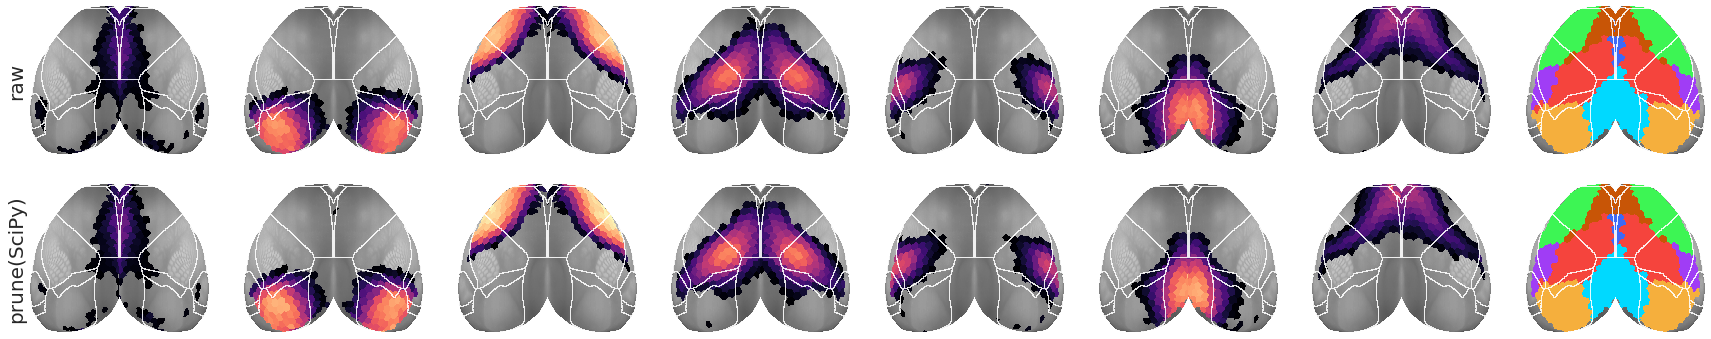

[0.978, 0.979]

In [6]:
[e[-1] for e in bt_ca.pi_symmetry_score(avg(bt_ca.run_pi))]

[0.985, 0.979]

## Members: various $\mu$

In [10]:
se, f = bt_ca.fit_boot(n_resamples=int(1e5))
f

'se-BCa_group-pi_1.0e+05'

In [11]:
pi = avg(bt_ca.pi_prune)
members = np.zeros(pi.shape)
alpha = 0.05

# mu_vals = [0.02, 0.05] + [i / bt_ca.num_k for i in [1, 2, 3, 4]]
mu_vals = [0.5, 0.2, 0.05, 0.0]
for mu in mu_vals:
    reject, pvals = bt_ca.ttest(se, pi, mu=mu, alpha=alpha)
    members[reject == 1] += 1
members /= np.nanmax(members)

mu_vals

[0.5, 0.2, 0.05, 0.0]

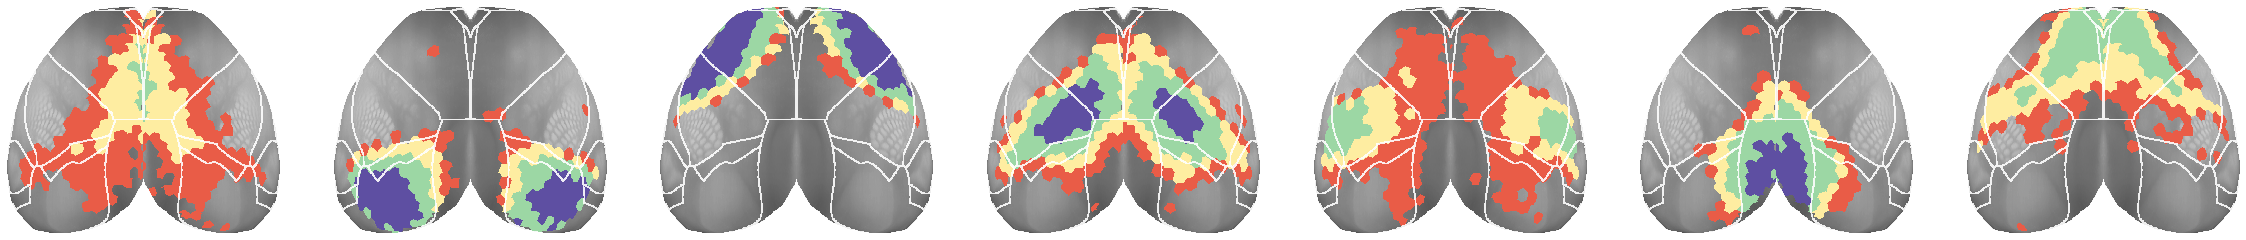

In [12]:
_ = bt_ca.show(
    data=members.astype(float),
    vmin=0.1,
    vmax=1.0,
    cmap='Spectral',
    add_disjoint=False,
    figsize=(40, 8),
)

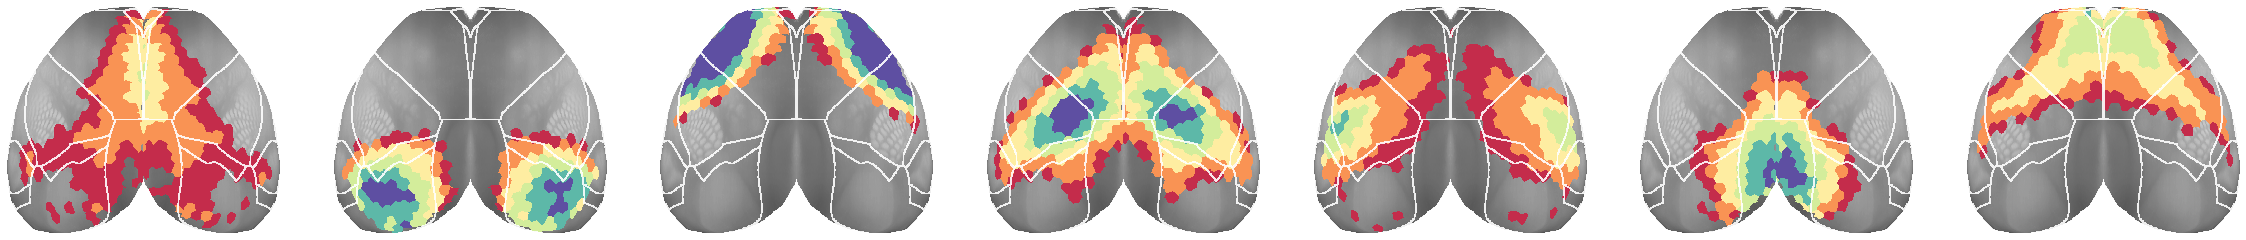

In [17]:
pi = avg(bt_ca.pi_prune)
members = np.zeros(pi.shape)
alpha = 0.05

mu_vals = [0.01, 0.05] + [i / bt_ca.num_k for i in [1, 2, 3, 4]]
for mu in sorted(mu_vals, reverse=True):
    reject, pvals = bt_ca.ttest(se, pi, mu=mu, alpha=alpha)
    members[reject == 1] += 1
members /= np.nanmax(members)

mu_vals

[
    0.01,
    0.05,
    0.14285714285714285,
    0.2857142857142857,
    0.42857142857142855,
    0.5714285714285714
]

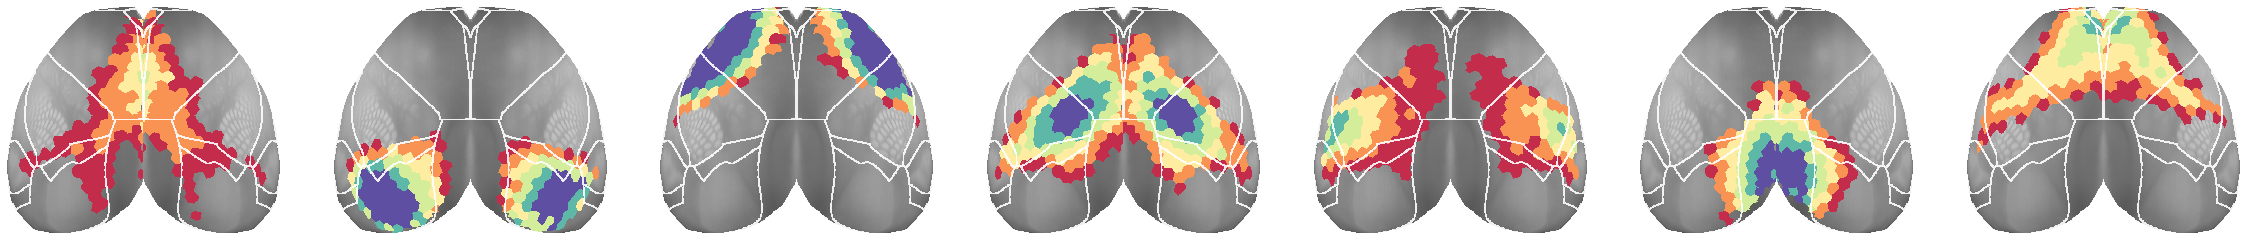

In [18]:
_ = bt_ca.show(
    data=members.astype(float),
    vmin=0.1,
    vmax=1.0,
    cmap='Spectral',
    add_disjoint=False,
    figsize=(40, 8),
)

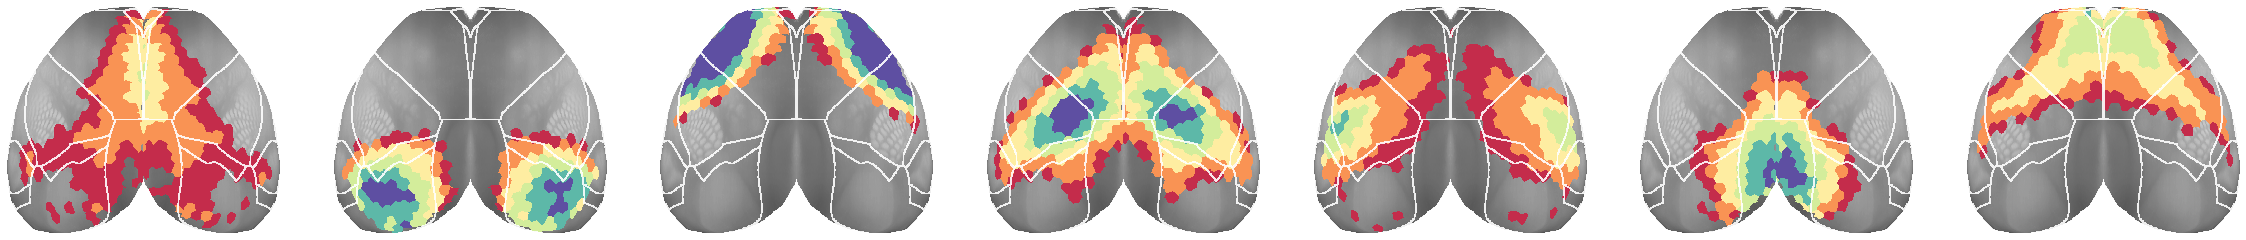

## Finally, carto

In [82]:
df = bt_ca.mk_cartography_df()

In [83]:
pi = bn.nanmean(bt_ca.pi_prune, -3)
ent = sp_stats.entropy(pi, axis=-2) / np.log(pi.shape[-2])

In [84]:
x = np.concatenate([
    np.expand_dims(ent, -2),
    np.expand_dims(bt_ca.run_deg, -2),
], axis=-2)
x.shape

(10, 3, 4, 2, 542)

In [85]:
se_carto = bt_ca.get_booter(int(1e5))(x)
se_carto.shape

(2, 542)

<AxesSubplot:ylabel='Count'>

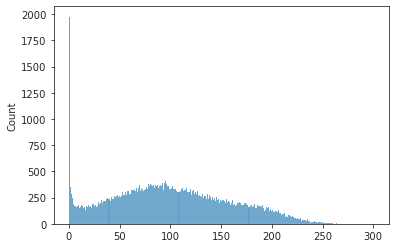

In [86]:
sns.histplot(bt_ca.run_deg.ravel(), bins=np.linspace(0, 300, 301))

<AxesSubplot:ylabel='Count'>

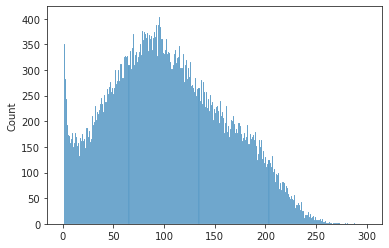

In [87]:
sns.histplot(bt_ca.run_deg[bt_ca.run_deg.nonzero()], bins=np.linspace(0, 300, 301))

In [88]:
ci, dof = 0.95, 9
whis = np.round((1 + ci) / 2, 5)
tval = sp_stats.t.ppf(whis, dof)

tval

2.2621571627409915

In [89]:
vlines = [df['entropy'].quantile(q) for q in [0.25, 0.5, 0.75]]
hlines = [df['degree'].quantile(q) for q in [0.25, 0.5, 0.75]]

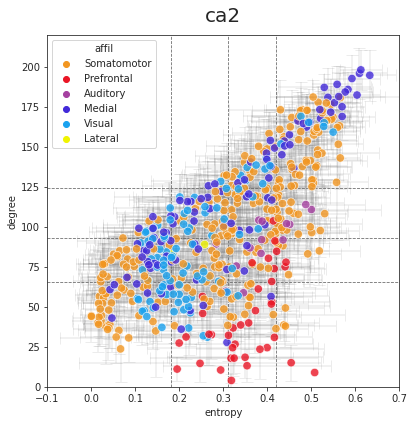

In [90]:
fig, ax = create_figure(1, 1, (8, 6), 'all', 'all')

for x in vlines:
    ax.axvline(x, color='dimgrey', ls='--', lw=0.8, zorder=0)
for y in hlines:
    ax.axhline(y, color='dimgrey', ls='--', lw=0.8, zorder=0)

sns.scatterplot(
    data=df,
    x='entropy',
    y='degree',
    hue='affil',
    palette=bt_ca.affil['colors'],
    s=70,
    alpha=0.8,
    ax=ax,
)
ax.set_title('ca2', fontsize=20, y=1.02)

ax.errorbar(
    x=df['entropy'].values,
    y=df['degree'].values,
    xerr=tval * se_carto[0],
    yerr=tval * se_carto[1],
    color='dimgrey',
    errorevery=1,
    capsize=6,
    alpha=0.12,
    ls='none',
    zorder=0,
)

xlim = (-0.1, 0.70)
ylim = (0, 220)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
aspect = (max(xlim) - min(xlim)) / (max(ylim) - min(ylim))
ax.set_aspect(aspect, adjustable='box')
# name = 'carto-group'
# figname = f"{name}.pdf"
# fig.savefig(pjoin(save_dir, figname), **fig_kws)


plt.show()

In [91]:
selected_nodes = [n for n, e in enumerate(bt_ca.affil_included) if e == 'Prefrontal']
len(selected_nodes)

38

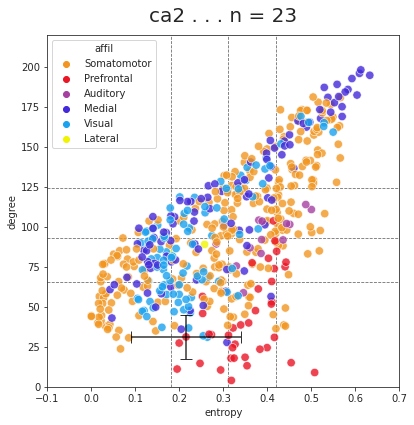

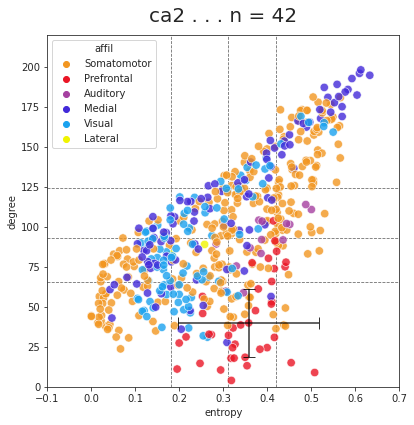

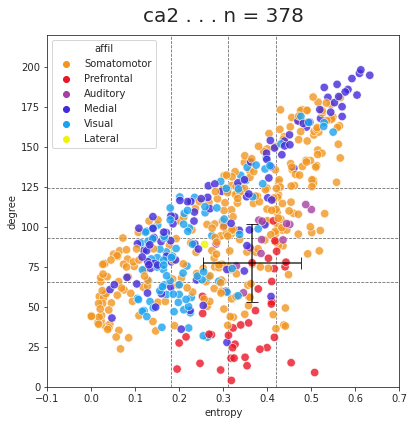

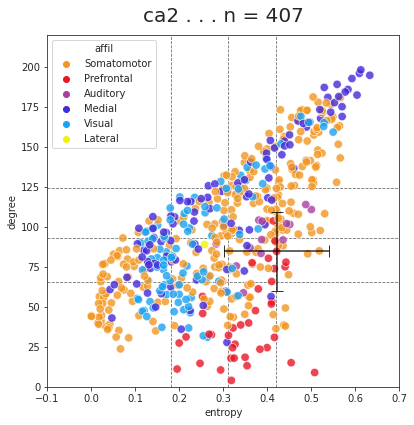

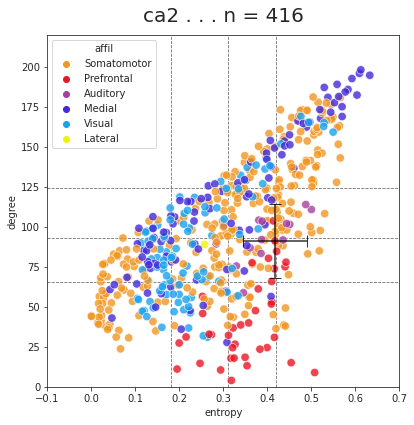

In [94]:
for n in [23, 42, 378, 407, 416]:
    fig, ax = create_figure(1, 1, (8, 6), 'all', 'all')

    for x in vlines:
        ax.axvline(x, color='dimgrey', ls='--', lw=0.8, zorder=0)
    for y in hlines:
        ax.axhline(y, color='dimgrey', ls='--', lw=0.8, zorder=0)

    sns.scatterplot(
        data=df,
        x='entropy',
        y='degree',
        hue='affil',
        palette=bt_ca.affil['colors'],
        s=70,
        alpha=0.8,
        ax=ax,
    )
    ax.set_title(f'ca2 . . . n = {n}', fontsize=20, y=1.02)

    ax.errorbar(
        x=df['entropy'].values[n],
        y=df['degree'].values[n],
        xerr=tval * se_carto[0][n],
        yerr=tval * se_carto[1][n],
        color='k',
        errorevery=1,
        capsize=6,
        alpha=0.8,
        ls='none',
        # zorder=0,
    )

    xlim = (-0.1, 0.70)
    ylim = (0, 220)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    aspect = (max(xlim) - min(xlim)) / (max(ylim) - min(ylim))
    ax.set_aspect(aspect, adjustable='box')
    # name = 'carto-group'
    # figname = f"{name}.pdf"
    # fig.savefig(pjoin(save_dir, figname), **fig_kws)


    plt.show()

In [95]:
df = bt_bo.mk_cartography_df()

In [96]:
pi = bn.nanmean(bt_bo.pi_prune, -3)
ent = sp_stats.entropy(pi, axis=-2) / np.log(pi.shape[-2])

In [97]:
x = np.concatenate([
    np.expand_dims(ent, -2),
    np.expand_dims(bt_bo.run_deg, -2),
], axis=-2)
x.shape

(10, 3, 4, 2, 542)

In [98]:
se_carto = bt_bo.get_booter(int(1e5))(x)
se_carto.shape

(2, 542)

<AxesSubplot:ylabel='Count'>

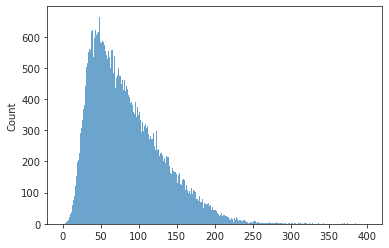

In [99]:
sns.histplot(bt_bo.run_deg.ravel(), bins=np.linspace(0, 400, 401))

In [100]:
ci, dof = 0.95, 9
whis = (1 + ci) / 2
tval = sp_stats.t.ppf(whis, dof)

tval

2.2621571627409915

In [101]:
vlines = [df['entropy'].quantile(q) for q in [0.25, 0.5, 0.75]]
hlines = [df['degree'].quantile(q) for q in [0.25, 0.5, 0.75]]

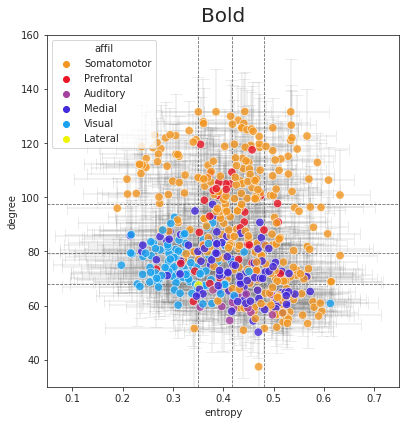

In [102]:
fig, ax = create_figure(1, 1, (8, 6), 'all', 'all')

for x in vlines:
    ax.axvline(x, color='dimgrey', ls='--', lw=0.8, zorder=0)
for y in hlines:
    ax.axhline(y, color='dimgrey', ls='--', lw=0.8, zorder=0)

sns.scatterplot(
    data=df,
    x='entropy',
    y='degree',
    hue='affil',
    palette=bt_bo.affil['colors'],
    s=70,
    alpha=0.8,
    ax=ax,
)
ax.set_title('Bold', fontsize=20, y=1.02)

ax.errorbar(
    x=df['entropy'].values,
    y=df['degree'].values,
    xerr=tval * se_carto[0],
    yerr=tval * se_carto[1],
    color='dimgrey',
    errorevery=1,
    capsize=6,
    alpha=0.12,
    ls='none',
    zorder=0,
)

xlim = (0.05, 0.75)
ylim = (30, 160)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
aspect = (max(xlim) - min(xlim)) / (max(ylim) - min(ylim))
ax.set_aspect(aspect, adjustable='box')
# name = 'carto-group'
# figname = f"{name}.pdf"
# fig.savefig(pjoin(save_dir, figname), **fig_kws)


plt.show()

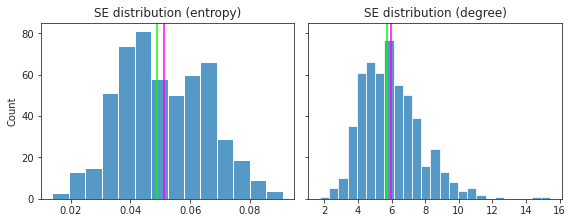

In [103]:
fig, axes = create_figure(1, 2, (8, 3.2), sharey='row')
for i, ax in enumerate(axes.flat):
    sns.histplot(se_carto[i], ax=ax)
    ax.axvline(np.nanmedian(se_carto[i]), color='lime')
    ax.axvline(np.nanmean(se_carto[i]), color='magenta')
axes[0].set_title('SE distribution (entropy)')
axes[1].set_title('SE distribution (degree)')
plt.show()

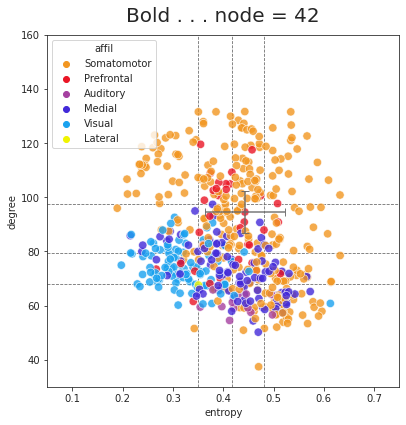

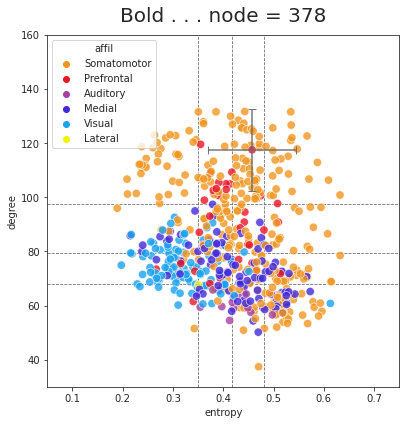

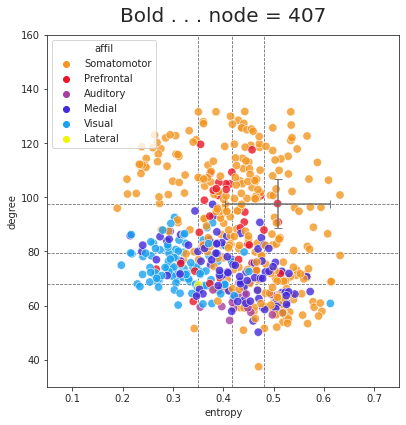

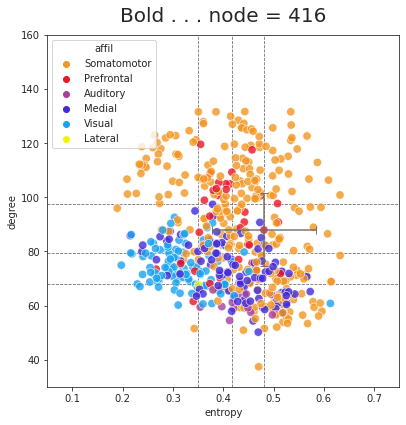

In [106]:
for n in [42, 378, 407, 416]:
    fig, ax = create_figure(1, 1, (8, 6), 'all', 'all')

    for x in vlines:
        ax.axvline(x, color='dimgrey', ls='--', lw=0.8, zorder=0)
    for y in hlines:
        ax.axhline(y, color='dimgrey', ls='--', lw=0.8, zorder=0)

    sns.scatterplot(
        data=df,
        x='entropy',
        y='degree',
        hue='affil',
        palette=bt_bo.affil['colors'],
        s=70,
        alpha=0.8,
        ax=ax,
    )
    ax.set_title(f'Bold . . . node = {n}', fontsize=20, y=1.02)

    ax.errorbar(
        x=df['entropy'].values[n],
        y=df['degree'].values[n],
        xerr=tval * se_carto[0][n],
        yerr=tval * se_carto[1][n],
        color='dimgrey',
        errorevery=1,
        capsize=4,
        alpha=0.9,
        ls='none',
        # zorder=0,
    )

    xlim = (0.05, 0.75)
    ylim = (30, 160)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    aspect = (max(xlim) - min(xlim)) / (max(ylim) - min(ylim))
    ax.set_aspect(aspect, adjustable='box')
    # name = 'carto-group'
    # figname = f"{name}.pdf"
    # fig.savefig(pjoin(save_dir, figname), **fig_kws)


    plt.show()

In [149]:
n = 0

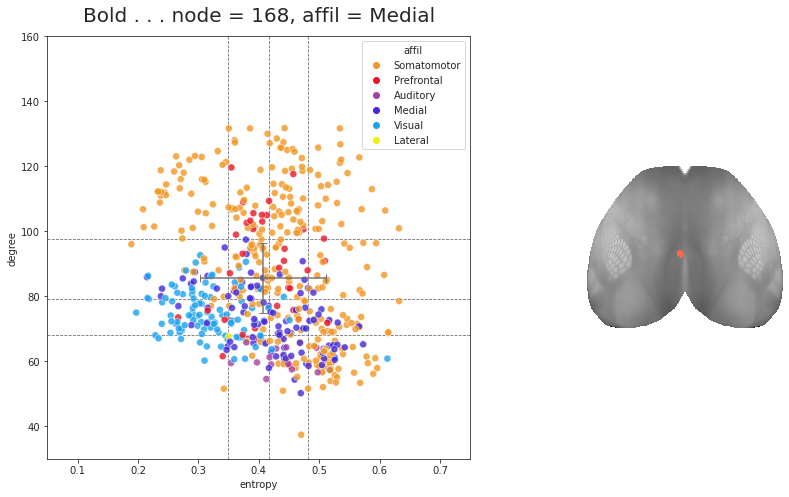

In [318]:
fig, axes = create_figure(1, 2, (13, 7), width_ratios=[4, 1])

for x in vlines:
    axes[0].axvline(x, color='dimgrey', ls='--', lw=0.8, zorder=0)
for y in hlines:
    axes[0].axhline(y, color='dimgrey', ls='--', lw=0.8, zorder=0)

sns.scatterplot(
    data=df,
    x='entropy',
    y='degree',
    hue='affil',
    palette=bt_bo.affil['colors'],
    s=50,
    alpha=0.8,
    ax=axes[0],
)
axes[0].set_title(f'Bold . . . node = {n}, affil = {bt_ca.affil_included[n]}', fontsize=20, y=1.02)

axes[0].errorbar(
    x=df['entropy'].values[n],
    y=df['degree'].values[n],
    xerr=tval * se_carto[0][n],
    yerr=tval * se_carto[1][n],
    color='dimgrey',
    errorevery=1,
    capsize=4,
    alpha=0.9,
    ls='none',
    # zorder=0,
)

xlim = (0.05, 0.75)
ylim = (30, 160)
axes[0].set_xlim(xlim)
axes[0].set_ylim(ylim)
aspect = (max(xlim) - min(xlim)) / (max(ylim) - min(ylim))
axes[0].set_aspect(aspect, adjustable='box')
# name = 'carto-group'
# figname = f"{name}.pdf"
# fig.savefig(pjoin(save_dir, figname), **fig_kws)

axes[1].imshow(mwh(top == 0, top), cmap='Greys_r')
x2p = parcel_top == mice.parcel.encode(bt_ca.n2l[n])
axes[1].imshow(mwh(~x2p, x2p), cmap='Reds', vmin=0, vmax=2)
remove_ticks(axes[1])

plt.show()

n += 1

In [115]:
top, _ = bt_ca.load_top_flat()
parcel_top, _ = mice.parcel.load_top_flat()
parcel_top, top = filter_boundaries([parcel_top, top], top > 0)

<matplotlib.image.AxesImage object at 0x7f90165505e0>

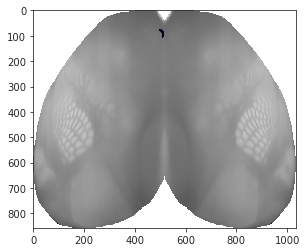